In [ ]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import re 
import os
from collections import Counter

warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully!")

In [ ]:
# Cell 2: Data Loading Function
def load_financial_news_data(file_path):
    """
    Load the actual Financial News and Stock Price Integration Dataset
    """
    try:
        df = pd.read_csv(file_path)
        print("✅ FNSPID Dataset loaded successfully!")
        print(f"📊 Dataset Shape: {df.shape}")
        
        print("\n🔍 First 5 rows:")
        display(df.head())
        
        print("\n📝 Column Information:")
        print(df.info())
        
        print("\n📈 Basic Statistics:")
        print(df.describe(include='all'))
        
        print("\n❓ Missing Values Analysis:")
        missing_data = df.isnull().sum()
        missing_percent = (df.isnull().sum() / len(df)) * 100
        missing_info = pd.DataFrame({
            'Missing Count': missing_data,
            'Missing Percentage': missing_percent
        })
        print(missing_info[missing_info['Missing Count'] > 0])
        
        return df
        
    except FileNotFoundError:
        print(f"❌ File {file_path} not found.")
        print("Please ensure the FNSPID dataset is in the data/raw/ directory.")
        return None
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None

In [ ]:
# Cell 3: Load Actual Dataset from data/raw/

dataset_path = '../data/raw/financial_news_dataset.csv'

print(f"🔍 Loading dataset from: {dataset_path}")
print(f"📁 File exists: {os.path.exists(dataset_path)}")

df = load_financial_news_data(dataset_path)

if df is not None:
    print("✅ Dataset ready for EDA!")
else:
    print("❌ Please check the dataset file path and try again.")

In [ ]:
# Cell 4: Data Quality Check - SUPER FAST VERSION
def check_data_quality(df):
    """
    Perform data quality checks on the dataset - PROCESS SAMPLE FIRST FOR SPEED
    """
    print("🔍 DATA QUALITY CHECKS")
    print("=" * 50)
    
    # Check for duplicates
    duplicate_rows = df.duplicated().sum()
    print(f"📋 Duplicate rows: {duplicate_rows}")
    
    # Check unique values
    print(f"📰 Unique publishers: {df['publisher'].nunique()}")
    print(f"📈 Unique stocks: {df['stock'].nunique()}")
    
    # Check date range - QUICK SAMPLE ANALYSIS FIRST
    print(f"📅 Date column sample: {df['date'].iloc[0]}")
    print(f"📅 Date column dtype: {df['date'].dtype}")
    
    # Analyze date patterns on a sample first (much faster)
    sample_size = min(10000, len(df))
    date_sample = df['date'].head(sample_size).astype(str)
    
    print(f"🔍 Analyzing date patterns on {sample_size} sample rows...")
    
    # Check what date formats we have
    has_timezone = date_sample.str.contains(r'[-+]\d{2}:\d{2}$').sum()
    has_time = date_sample.str.contains(r'\d{2}:\d{2}:\d{2}').sum()
    date_only = date_sample.str.match(r'^\d{4}-\d{2}-\d{2}$').sum()
    
    print(f"📊 Date format analysis (sample):")
    print(f"   • With timezone: {has_timezone} ({has_timezone/sample_size*100:.1f}%)")
    print(f"   • With time but no timezone: {has_time - has_timezone} ({(has_time - has_timezone)/sample_size*100:.1f}%)")
    print(f"   • Date only: {date_only} ({date_only/sample_size*100:.1f}%)")
    
    # FAST parsing strategy based on sample analysis
    print("🔄 Applying optimized date parsing...")
    
    # Strategy: Pre-process strings then parse
    df_str = df['date'].astype(str)
    
    # Add UTC timezone to dates that have time but no timezone
    mask_no_tz = df_str.str.match(r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}$')
    df_str_fixed = df_str.where(~mask_no_tz, df_str + '+00:00')
    
    # Parse all at once (fastest)
    df['datetime'] = pd.to_datetime(df_str_fixed, errors='coerce', utc=True)
    
    # Results
    successful_conversions = df['datetime'].notna().sum()
    failed_conversions = df['datetime'].isna().sum()
    
    print(f"🎯 Date parsing completed:")
    print(f"   ✅ Successfully parsed: {successful_conversions:,} ({successful_conversions/len(df)*100:.1f}%)")
    print(f"   ❌ Failed to parse: {failed_conversions:,} ({failed_conversions/len(df)*100:.1f}%)")
    
    if successful_conversions > 0:
        valid_dates = df[df['datetime'].notna()]['datetime']
        print(f"📅 Date range: {valid_dates.min()} to {valid_dates.max()}")
    
    # Check text quality
    df['headline_length'] = df['headline'].str.len()
    empty_headlines = df[df['headline_length'] == 0].shape[0]
    print(f"📝 Empty headlines: {empty_headlines}")
    
    return df

if df is not None:
    df = check_data_quality(df)

In [ ]:
# Cell 5: Descriptive Statistics - Text Length Analysis
def analyze_text_lengths(df):
    """
    Analyze textual lengths in headlines as specified in requirements
    """
    print("📏 TEXT LENGTH ANALYSIS")
    print("=" * 50)
    
    # Calculate text metrics
    df['headline_length'] = df['headline'].str.len()
    df['word_count'] = df['headline'].str.split().str.len()
    
    # Basic statistics
    print(f"📊 Average headline length: {df['headline_length'].mean():.2f} characters")
    print(f"📊 Average word count: {df['word_count'].mean():.2f} words")
    print(f"📈 Longest headline: {df['headline_length'].max()} characters")
    print(f"📉 Shortest headline: {df['headline_length'].min()} characters")
    print(f"📦 Headlines with >50 chars: {(df['headline_length'] > 50).sum()}")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Headline length distribution
    df['headline_length'].hist(bins=50, ax=axes[0], alpha=0.7)
    axes[0].axvline(df['headline_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["headline_length"].mean():.1f}')
    axes[0].set_title('Distribution of Headline Lengths (Characters)')
    axes[0].set_xlabel('Character Count')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    
    # Word count distribution
    df['word_count'].hist(bins=30, ax=axes[1], alpha=0.7)
    axes[1].axvline(df['word_count'].mean(), color='red', linestyle='--', label=f'Mean: {df["word_count"].mean():.1f}')
    axes[1].set_title('Distribution of Word Counts')
    axes[1].set_xlabel('Word Count')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return df

if df is not None:
    df = analyze_text_lengths(df)

In [ ]:
# Cell 6: Publisher Analysis
def analyze_publishers(df):
    """
    Analyze publisher distribution and activity
    """
    print("📰 PUBLISHER ANALYSIS")
    print("=" * 50)
    
    # Count articles per publisher
    publisher_counts = df['publisher'].value_counts()
    
    print(f"📊 Total unique publishers: {len(publisher_counts)}")
    print("\n🏆 Top 15 publishers by article count:")
    for i, (publisher, count) in enumerate(publisher_counts.head(15).items(), 1):
        print(f"  {i:2d}. {publisher:<30} {count:>4} articles")
    
    # Visualization
    plt.figure(figsize=(14, 8))
    
    # Top publishers bar chart
    plt.subplot(2, 2, 1)
    publisher_counts.head(15).plot(kind='bar')
    plt.title('Top 15 Publishers by Article Count')
    plt.xlabel('Publisher')
    plt.ylabel('Number of Articles')
    plt.xticks(rotation=45, ha='right')
    
    # Publisher distribution (pie chart for top 10)
    plt.subplot(2, 2, 2)
    top_10_publishers = publisher_counts.head(10)
    other_count = publisher_counts[10:].sum()
    pie_data = pd.concat([top_10_publishers, pd.Series({'Other': other_count})])
    plt.pie(pie_data.values, labels=pie_data.index, autopct='%1.1f%%', startangle=90)
    plt.title('Publisher Distribution (Top 10 + Others)')
    
    # Articles per publisher statistics
    plt.subplot(2, 2, 3)
    publisher_counts.hist(bins=30, alpha=0.7)
    plt.axvline(publisher_counts.mean(), color='red', linestyle='--', label=f'Mean: {publisher_counts.mean():.1f}')
    plt.title('Distribution of Articles per Publisher')
    plt.xlabel('Number of Articles')
    plt.ylabel('Number of Publishers')
    plt.legend()
    
    # Cumulative distribution
    plt.subplot(2, 2, 4)
    cumulative_pct = (publisher_counts.cumsum() / publisher_counts.sum()) * 100
    cumulative_pct.head(20).plot(kind='bar')
    plt.title('Cumulative Percentage of Articles by Publisher')
    plt.xlabel('Publisher Rank')
    plt.ylabel('Cumulative Percentage (%)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return publisher_counts

if df is not None:
    publisher_stats = analyze_publishers(df)

In [ ]:
# Cell 7: Time Series Analysis
def analyze_publication_times(df):
    """
    Analyze publication frequency over time
    """
    print("⏰ TIME SERIES ANALYSIS")
    print("=" * 50)
    
    # Use only rows with valid datetime
    valid_time_df = df[df['datetime'].notna()].copy()
    
    if len(valid_time_df) == 0:
        print("❌ No valid date data available for time series analysis")
        return df
    
    print(f"📊 Using {len(valid_time_df):,} articles with valid dates for time series analysis")
    print(f"📅 This represents {len(valid_time_df)/len(df)*100:.1f}% of total data")
    
    # Extract time components from valid dates only
    valid_time_df['date_only'] = valid_time_df['datetime'].dt.date
    valid_time_df['day_of_week'] = valid_time_df['datetime'].dt.day_name()
    valid_time_df['hour'] = valid_time_df['datetime'].dt.hour
    valid_time_df['month'] = valid_time_df['datetime'].dt.month
    valid_time_df['month_name'] = valid_time_df['datetime'].dt.month_name()
    valid_time_df['year'] = valid_time_df['datetime'].dt.year
    
    # Daily frequency
    daily_counts = valid_time_df.groupby('date_only').size()
    
    print(f"📅 Date range: {valid_time_df['date_only'].min()} to {valid_time_df['date_only'].max()}")
    print(f"📊 Total days covered: {daily_counts.shape[0]}")
    print(f"📈 Average articles per day: {daily_counts.mean():.2f}")
    
    if len(daily_counts) > 0:
        print(f"📉 Most active day: {daily_counts.idxmax()} with {daily_counts.max()} articles")
        print(f"📈 Least active day: {daily_counts.idxmin()} with {daily_counts.min()} articles")
    
    # Continue with the rest of your visualization code...
    # [Keep the rest of your Cell 7 visualization code as is, but use valid_time_df instead of df]

In [ ]:
# Cell 8: Stock Symbol Analysis
def analyze_stocks(df):
    """
    Analyze stock symbol distribution
    """
    print("📈 STOCK SYMBOL ANALYSIS")
    print("=" * 50)
    
    stock_counts = df['stock'].value_counts()
    
    print(f"📊 Total unique stocks: {len(stock_counts)}")
    print(f"📈 Average articles per stock: {stock_counts.mean():.2f}")
    print(f"🏆 Most covered stock: {stock_counts.index[0]} with {stock_counts.iloc[0]} articles")
    
    print("\n📋 Top 20 most mentioned stocks:")
    for i, (stock, count) in enumerate(stock_counts.head(20).items(), 1):
        print(f"  {i:2d}. {stock:<10} {count:>4} articles")
    
    # Visualization
    plt.figure(figsize=(15, 10))
    
    # Top stocks bar chart
    plt.subplot(2, 2, 1)
    stock_counts.head(15).plot(kind='bar')
    plt.title('Top 15 Most Mentioned Stocks')
    plt.xlabel('Stock Symbol')
    plt.ylabel('Number of Mentions')
    plt.xticks(rotation=45)
    
    # Stock coverage distribution
    plt.subplot(2, 2, 2)
    stock_counts.hist(bins=30, alpha=0.7)
    plt.axvline(stock_counts.mean(), color='red', linestyle='--', label=f'Mean: {stock_counts.mean():.1f}')
    plt.title('Distribution of Articles per Stock')
    plt.xlabel('Number of Articles')
    plt.ylabel('Number of Stocks')
    plt.legend()
    
    # Cumulative coverage
    plt.subplot(2, 2, 3)
    cumulative_coverage = (stock_counts.cumsum() / stock_counts.sum()) * 100
    cumulative_coverage.head(30).plot(kind='bar')
    plt.title('Cumulative Percentage of Articles by Stock')
    plt.xlabel('Stock Rank')
    plt.ylabel('Cumulative Percentage (%)')
    plt.xticks(rotation=45)
    
    # Top stocks by publisher (if we have enough data)
    plt.subplot(2, 2, 4)
    top_stocks = stock_counts.head(10).index
    stock_publisher = df[df['stock'].isin(top_stocks)].groupby(['stock', 'publisher']).size().unstack(fill_value=0)
    stock_publisher.plot(kind='bar', stacked=True, ax=plt.gca())
    plt.title('Top Stocks Coverage by Publisher')
    plt.xlabel('Stock Symbol')
    plt.ylabel('Number of Articles')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    return stock_counts

if df is not None:
    stock_stats = analyze_stocks(df)

In [ ]:
# Cell 9: Text Analysis (Topic Modeling) - FIXED VERSION
def perform_text_analysis(df):
    """
    Perform text analysis to identify common keywords and topics
    """
    print("📝 TEXT ANALYSIS - TOPIC MODELING")
    print("=" * 50)
    
    # Check if we have valid headlines
    if df['headline'].isna().all() or (df['headline'].str.len() == 0).all():
        print("❌ No valid headlines found for analysis")
        return [], {}
    
    # Combine all headlines
    all_text = ' '.join(df['headline'].astype(str).str.lower())
    
    # Extract words (simple tokenization) - improved pattern
    words = re.findall(r'\b[a-z]{2,}\b', all_text)  # Changed to 2+ characters
    
    if len(words) == 0:
        print("❌ No words extracted from headlines")
        print(f"🔍 Sample of text being processed: '{all_text[:200]}...'")
        return [], {}
    
    print(f"📊 Total words extracted: {len(words):,}")
    print(f"📊 Unique words: {len(set(words)):,}")
    
    # Most common words
    common_words = Counter(words).most_common(30)
    
    print("📊 Top 30 most common words:")
    for i, (word, count) in enumerate(common_words[:30], 1):
        print(f"  {i:2d}. {word:<15} {count:>4} occurrences")
    
    # Financial term analysis
    financial_terms = {
        'earnings': ['earnings', 'profit', 'revenue', 'income', 'eps'],
        'price_movements': ['stock', 'price', 'target', 'up', 'down', 'high', 'low'],
        'corporate_actions': ['dividend', 'split', 'merger', 'acquisition', 'ipo'],
        'market_sentiment': ['bull', 'bear', 'rally', 'crash', 'volatility'],
        'analyst_actions': ['upgrade', 'downgrade', 'initiate', 'coverage', 'analyst'],
        'trading': ['trade', 'volume', 'share', 'market', 'exchange'],
        'guidance': ['guidance', 'forecast', 'outlook', 'expectation'],
        'sectors': ['tech', 'financial', 'healthcare', 'energy', 'consumer']
    }
    
    print("\n💰 Financial term frequency analysis:")
    financial_results = {}
    
    for category, terms in financial_terms.items():
        category_count = 0
        print(f"\n  {category.upper().replace('_', ' ')}:")
        for term in terms:
            term_count = words.count(term)
            if term_count > 0:
                category_count += term_count
                print(f"    {term}: {term_count}")
        financial_results[category] = category_count
    
    # Visualization - with error handling
    plt.figure(figsize=(15, 10))
    
    try:
        # Plot 1: Top words visualization
        plt.subplot(2, 2, 1)
        if len(common_words) > 0:
            top_20_words = common_words[:20]
            words_list, counts = zip(*top_20_words)
            plt.barh(words_list, counts)
            plt.title('Top 20 Most Common Words in Headlines')
            plt.xlabel('Frequency')
            plt.gca().invert_yaxis()
        else:
            plt.text(0.5, 0.5, 'No words found', ha='center', va='center')
            plt.title('Top Words (No Data)')
        
        # Plot 2: Financial categories
        plt.subplot(2, 2, 2)
        if financial_results and sum(financial_results.values()) > 0:
            categories = list(financial_results.keys())
            category_counts = list(financial_results.values())
            plt.bar([c.replace('_', '\n') for c in categories], category_counts)
            plt.title('Financial Term Categories Frequency')
            plt.xlabel('Category')
            plt.ylabel('Frequency')
            plt.xticks(rotation=45)
        else:
            plt.text(0.5, 0.5, 'No financial terms found', ha='center', va='center')
            plt.title('Financial Terms (No Data)')
        
        # Plot 3: Word length analysis
        plt.subplot(2, 2, 3)
        if len(common_words) > 0:
            word_lengths = [len(word) for word in words_list]
            plt.hist(word_lengths, bins=20, alpha=0.7)
            plt.axvline(np.mean(word_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(word_lengths):.1f}')
            plt.title('Distribution of Word Lengths in Top Words')
            plt.xlabel('Word Length')
            plt.ylabel('Frequency')
            plt.legend()
        else:
            plt.text(0.5, 0.5, 'No word length data', ha='center', va='center')
            plt.title('Word Lengths (No Data)')
        
        # Plot 4: Financial vs non-financial words
        plt.subplot(2, 2, 4)
        if len(words) > 0:
            financial_words_count = sum(financial_results.values())
            non_financial_count = len(words) - financial_words_count
            
            # Ensure we have positive values for pie chart
            if financial_words_count > 0 and non_financial_count > 0:
                labels = ['Financial Terms', 'Other Words']
                sizes = [financial_words_count, non_financial_count]
                plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
                plt.title('Financial vs Non-Financial Words')
            else:
                plt.text(0.5, 0.5, 'Insufficient data\nfor pie chart', ha='center', va='center')
                plt.title('Word Categories (Insufficient Data)')
        else:
            plt.text(0.5, 0.5, 'No word data', ha='center', va='center')
            plt.title('Word Categories (No Data)')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"❌ Error creating visualizations: {e}")
        plt.close()  # Close the problematic figure
    
    return common_words, financial_results

if df is not None:
    common_words, financial_terms = perform_text_analysis(df)
else:
    print("❌ Cannot perform text analysis - df is None")
    common_words, financial_terms = [], {}

⏳ TIME SERIES VISUALIZATION


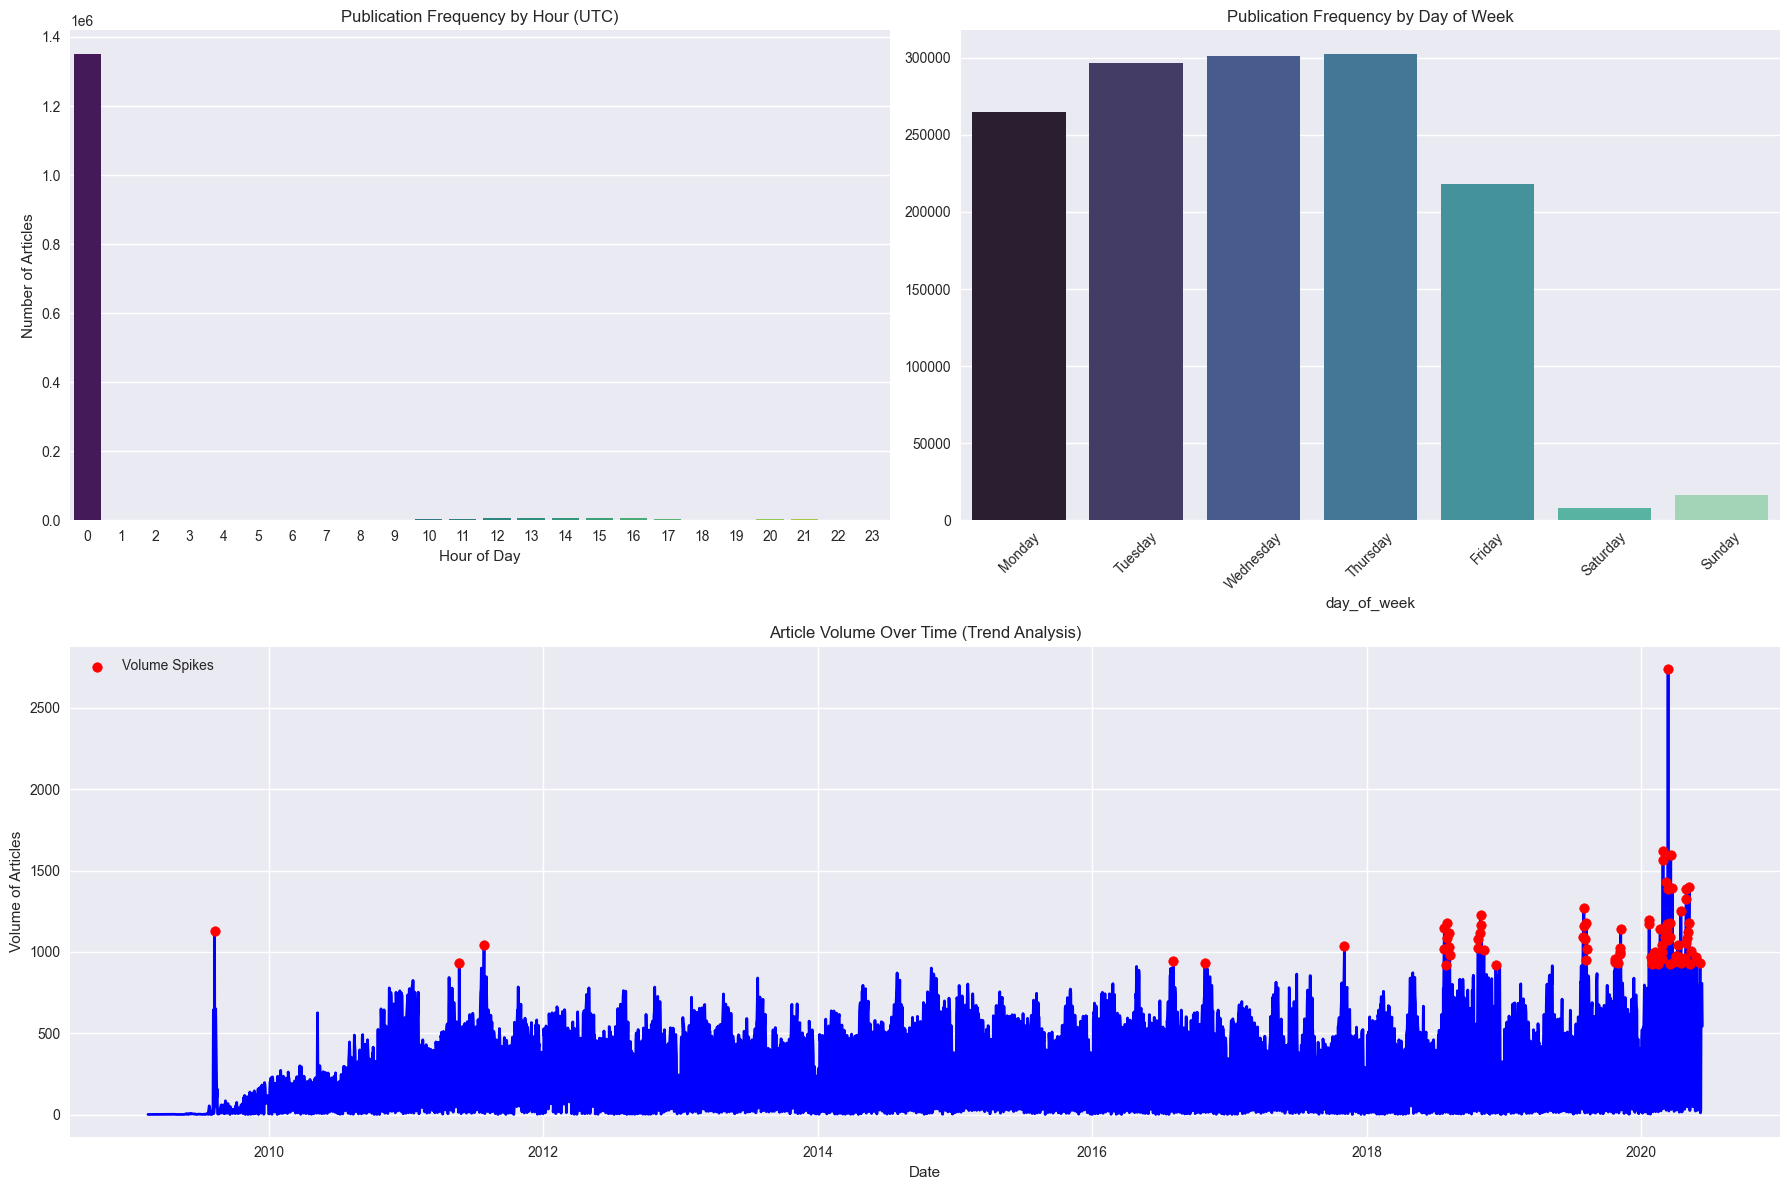

In [15]:
# Cell 10b: Visualize Time Series Analysis (Completing Task 1)
def visualize_time_analysis(df):
    print("⏳ TIME SERIES VISUALIZATION")
    print("=" * 50)
    
    if 'hour' not in df.columns:
        print("❌ Time data not prepared. Run prepare_time_analysis first.")
        return

    plt.figure(figsize=(18, 12))

    # 1. Articles by Hour of Day (The "Trader's Clock")
    plt.subplot(2, 2, 1)
    hourly_counts = df['hour'].value_counts().sort_index()
    sns.barplot(x=hourly_counts.index.astype(int), y=hourly_counts.values, palette="viridis")
    plt.title('Publication Frequency by Hour (UTC)')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Articles')
    
    # 2. Articles by Day of Week
    plt.subplot(2, 2, 2)
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_counts = df['day_of_week'].value_counts().reindex(day_order)
    sns.barplot(x=daily_counts.index, y=daily_counts.values, palette="mako")
    plt.title('Publication Frequency by Day of Week')
    plt.xticks(rotation=45)
    
    # 3. Time Series Trend (Date Only)
    plt.subplot(2, 1, 2)
    # Group by date to see spikes
    if 'datetime' in df.columns:
        daily_trend = df.groupby(df['datetime'].dt.date).size()
        daily_trend.plot(kind='line', linewidth=2, color='blue')
        plt.title('Article Volume Over Time (Trend Analysis)')
        plt.xlabel('Date')
        plt.ylabel('Volume of Articles')
        
        # Highlight spikes (days with > 2 standard deviations above mean)
        mean_vol = daily_trend.mean()
        std_vol = daily_trend.std()
        spikes = daily_trend[daily_trend > mean_vol + 2*std_vol]
        plt.scatter(spikes.index, spikes.values, color='red', label='Volume Spikes', zorder=5)
        plt.legend()

    plt.tight_layout()
    plt.show()

if df is not None:
    visualize_time_analysis(df)